In [209]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import scienceplots

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from nanonets.utils import logic_gate_sample, fitness, abundance, abundance_plot, load_boolean_results
from nanonets import Simulation

plt.style.use(["science","bright","grid"])
folder  = "~/bagheera/data/1_funding_period/phase_space_sample/"

### Surrogate Model Data

In [3]:
df  = pd.read_csv(f"{folder}Nx=9_Ny=9_Ne=8.csv")
df

,E0,E1,E2,E3,E4,E5,E6,E7,G,Eq_Jumps,Jumps,Observable,Error
0,0.01182,-0.00646,0.07780,-0.01338,-0.01870,-0.05314,-0.09545,0.0,0.0,100000.0,75000.0,-4.298110e+08,1.768656e+07
1,-0.01482,-0.04694,-0.02325,-0.04860,-0.05950,0.02327,0.08376,0.0,0.0,100000.0,185000.0,1.285388e+08,6.037295e+06
2,-0.05274,0.04227,-0.09091,-0.01855,0.00589,0.05421,-0.00289,0.0,0.0,100000.0,515000.0,5.635003e+07,2.693918e+06
3,0.00213,-0.00459,-0.01814,0.09199,-0.02235,0.06526,-0.00573,0.0,0.0,100000.0,125000.0,2.316145e+08,9.511503e+06
4,-0.01126,0.07502,0.07540,-0.02272,0.01470,-0.09880,-0.02350,0.0,0.0,100000.0,145000.0,-2.098581e+08,9.860593e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511995,-0.06973,0.09504,-0.01588,-0.09996,0.07834,-0.09402,-0.07039,0.0,0.0,100000.0,110000.0,-5.017856e+08,2.187199e+07
511996,0.07733,-0.00623,-0.06209,0.03033,0.02780,-0.09677,-0.05897,0.0,0.0,100000.0,90000.0,-4.592464e+08,1.821822e+07
511997,-0.09941,0.09229,0.01421,-0.00645,0.00811,0.09563,0.02607,0.0,0.0,100000.0,35000.0,4.677501e+08,2.064223e+07
511998,0.00438,-0.09770,0.05305,0.01252,-0.02944,0.05342,-0.04881,0.0,0.0,100000.0,1030000.0,-3.668070e+07,1.821193e+06


### Prepare and Split Data

In [6]:
X   = df.iloc[:,:7].values
y   = df['Observable'].values
y_e = df['Error'].values

X_train, X_test, y_train, y_test, y_e_train, y_e_test = train_test_split(X, y, y_e, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 409600
Testing set size: 102400


In [19]:
# param_grid = {
#     'n_estimators': [1000],
#     'learning_rate': [0.05, 0.1],
#     'num_leaves': [31, 50, 70]
# }

param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'num_leaves': [31, 50, 70]
}

# Initialize the model
lgbm = lgb.LGBMRegressor(objective='regression', random_state=42, verbose=-1)

In [20]:
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', # We use negative MSE because GridSearchCV tries to maximize the score
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[CV] END .learning_rate=0.1, n_estimators=100, num_leaves=31; total time= 7.9min
[CV] END .learning_rate=0.1, n_estimators=100, num_leaves=31; total time= 8.0min
[CV] END .learning_rate=0.1, n_estimators=100, num_leaves=31; total time= 8.1min
[CV] END .learning_rate=0.1, n_estimators=100, num_leaves=50; total time=10.0min
[CV] END .learning_rate=0.1, n_estimators=100, num_leaves=50; total time=10.0min
[CV] END .learning_rate=0.1, n_estimators=100, num_leaves=70; total time=10.1min
[CV] END .learning_rate=0.1, n_estimators=100, num_leaves=50; total time=10.1min
[CV] END .learning_rate=0.1, n_estimators=100, num_leaves=70; total time=10.2min
[CV] END .learning_rate=0.1, n_estimators=100, num_leaves=70; total time=10.2min


GridSearchCV(cv=3,
             estimator=LGBMRegressor(objective='regression', random_state=42,
                                     verbose=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'n_estimators': [100],
                         'num_leaves': [31, 50, 70]},
             scoring='neg_mean_squared_error', verbose=2)

In [31]:
best_model  = grid_search.best_estimator_
y_pred      = best_model.predict(X_test)
mse         = mean_squared_error(y_test, y_pred)
rmse        = np.sqrt(mse)
r2          = r2_score(y_test, y_pred)

print("\nFinal Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"RMSE / AVG(Error): {rmse/np.mean(y_e):.4f}")
print(f"R-squared (R2): {r2:.4f}")


Final Model Evaluation:
Mean Squared Error (MSE): 295913017676152.3750
Root Mean Squared Error (RMSE): 17202122.4759
RMSE / AVG(Error): 2.0207
R-squared (R2): 0.9960


Text(0, 0.5, 'Predicted Values')

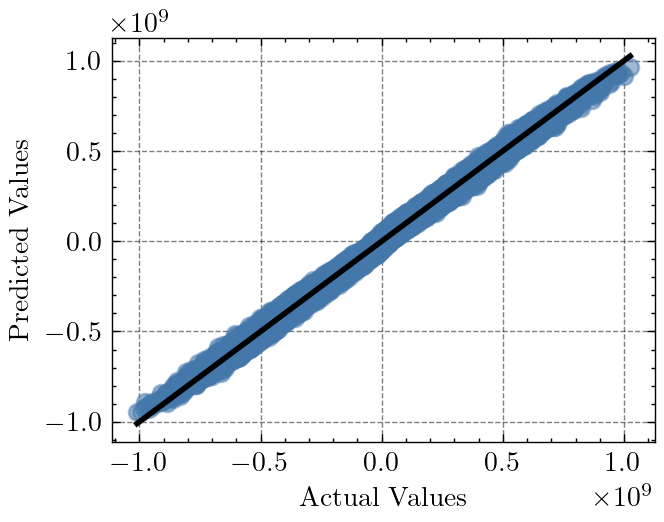

In [32]:
fig, ax = plt.subplots(dpi=200)
ax.scatter(y_test, y_pred, alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'black', linewidth=2)
ax.set_xlabel("Actual Values")
ax.set_ylabel("Predicted Values")

In [33]:
feature_names           = [f'$U{i}$' for i in range(X.shape[1])]
importances             = best_model.feature_importances_
feature_importance_df   = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df   = feature_importance_df.sort_values(by='importance', ascending=False)

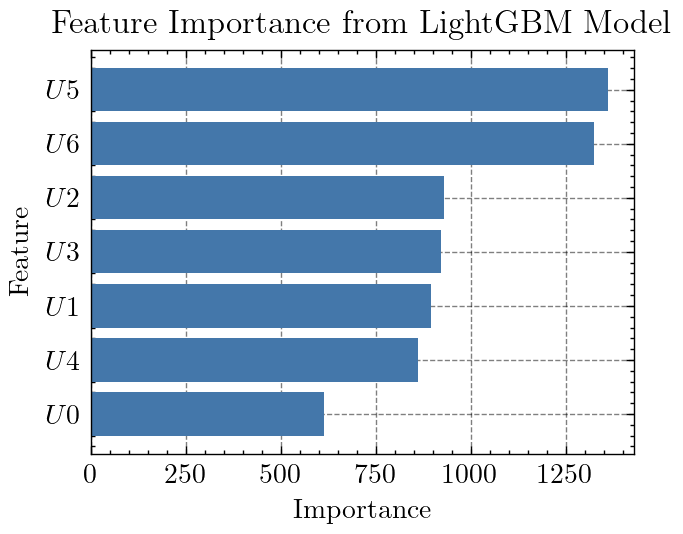

In [34]:
fig, ax = plt.subplots(dpi=200)
ax.barh(feature_importance_df['feature'], feature_importance_df['importance'])
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance from LightGBM Model')
ax.invert_yaxis()

# Surrogate Model

In [187]:
def get_transfer_coeff(n):
    topo = {"Nx": n, "Ny": n,
            "e_pos" : [[0,0], [int((n-1)/2),0], [n-1,0], [0,int((n-1)/2)],
                       [0,n-1], [n-1,int((n)/2)], [int((n)/2),(n-1)], [n-1,n-1]],
            "electrode_type" : ['constant']*8}
    sim_class = Simulation(topology_parameter=topo, pack_optimizer=False)
    sim_class.build_conductance_matrix()
    sim_class.init_transfer_coeffs()
    return sim_class.get_transfer_coeffs()

In [343]:
N_PARTICLES = 9
N_E         = 8
V_ON        = 0.05
V_OFF       = 0.0
V_RANGE     = 0.1
INPUT_POS   = [0,2]
SCALE       = False
INPUT_COL   = [f"E{INPUT_POS[0]}",f"E{INPUT_POS[1]}"]
N_SAMPLES   = 5000
TOPO        = {"Nx": N_PARTICLES, "Ny": N_PARTICLES,
                "e_pos" : [[0,0], [int((N_PARTICLES-1)/2),0], [N_PARTICLES-1,0],
                [0,int((N_PARTICLES-1)/2)], [0,N_PARTICLES-1],
                [N_PARTICLES-1,int((N_PARTICLES)/2)],
                [int((N_PARTICLES)/2),(N_PARTICLES-1)], [N_PARTICLES-1,N_PARTICLES-1]],
                "electrode_type" : ['constant']*N_E}

In [340]:
voltages        = logic_gate_sample(V_RANGE, INPUT_POS, N_SAMPLES, TOPO, V_ON, sample_technique='uniform')
if SCALE:
    t_coeff     = get_transfer_coeff(N_PARTICLES)
    factor      = np.ones_like(t_coeff, dtype=float)
    np.divide(t_coeff[INPUT_POS[0]], t_coeff, out=factor, where=t_coeff!=0)
    voltages    *= np.hstack((factor,0.0))
voltages        = voltages[:,:-2]
current_data    = best_model.predict(voltages)*1e-9
data            = pd.DataFrame(np.hstack((voltages,current_data[:,np.newaxis],np.zeros(shape=(len(current_data),1)))),
                               columns=([f"E{i}" for i in range(7)]+['Observable','Error'])).round(6)
fitness_data    = fitness(df=data, input_cols=INPUT_COL, off_state=V_OFF, on_state=V_ON, delta=0)
abundance_data  = abundance(fitness_data)

In [341]:
fitness_data

,E0,E1,E2,E3,E4,E5,E6,AND Fitness,OR Fitness,XOR Fitness,NAND Fitness,NOR Fitness,XNOR Fitness
0,0.025,0.042450,0.025,-0.078376,0.088151,-0.022579,-0.039728,3.206736,3.237730,0.004595,-3.206736,-3.237730,-0.004595
1,0.025,0.097161,0.025,0.011776,0.051548,0.064431,0.049369,2.843834,3.087448,0.042433,-2.843834,-3.087448,-0.042433
2,0.025,-0.043099,0.025,-0.024929,0.066011,0.050204,-0.011314,3.685889,2.727584,-0.146263,-3.685889,-2.727584,0.146263
3,0.025,-0.029179,0.025,-0.064405,0.036472,-0.032121,-0.033442,2.500658,2.975189,0.095903,-2.500658,-2.975189,-0.095903
4,0.025,0.059062,0.025,-0.095206,-0.008673,-0.057803,0.012369,2.268628,2.319525,0.013632,-2.268628,-2.319525,-0.013632
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.025,0.067078,0.025,-0.043442,-0.083615,-0.063856,-0.073796,2.553498,2.537376,-0.003668,-2.553498,-2.537376,0.003668
4996,0.025,0.001617,0.025,0.092886,0.093573,-0.041371,0.037723,3.257502,3.210278,-0.006952,-3.257502,-3.210278,0.006952
4997,0.025,0.092349,0.025,0.046783,-0.071556,-0.043951,-0.068990,2.652632,2.757817,0.021598,-2.652632,-2.757817,-0.021598
4998,0.025,0.056141,0.025,0.031796,-0.083364,-0.006720,-0.000563,3.081791,3.431416,0.050885,-3.081791,-3.431416,-0.050885


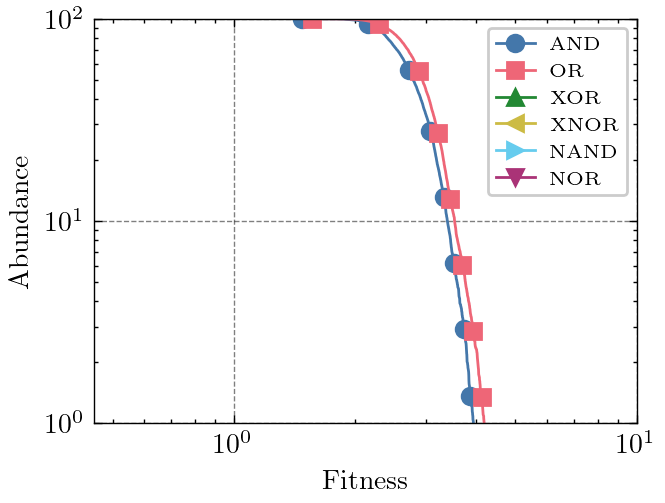

In [342]:
fig, ax = abundance_plot(abundance_data, y_limits=[1.0,100])

In [ ]:
df_true         = load_boolean_results("/home/jonasmensing/bagheera/data/1_funding_period/system_size_scaled/", N_PARTICLES, N_E, INPUT_COL, on_state=V_ON)
fitness_true    = fitness(df_true, input_cols=INPUT_COL)
abundance_true  = abundance(fitness_true)

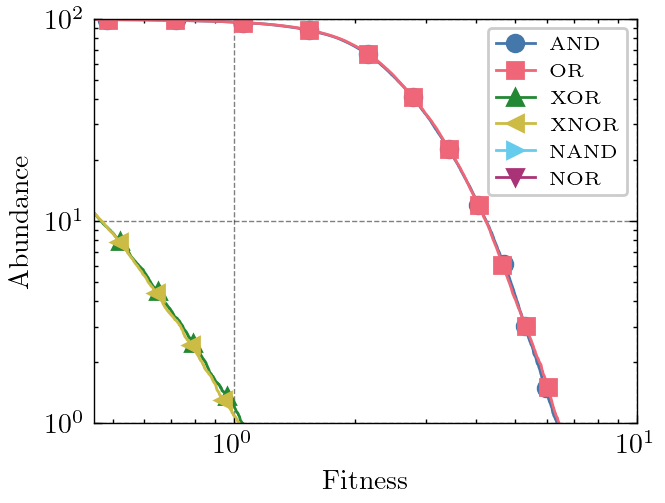

In [216]:
fig, ax = abundance_plot(abundance_true, y_limits=[1.0,100])

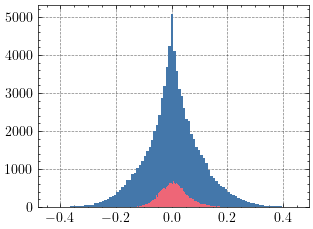

In [271]:
fig = plt.figure()
ax  = fig.add_subplot()
_ = ax.hist(df_true['Observable'].values*1e-9, bins=100)
_ = ax.hist(current_data, bins=100)